In [2]:
%matplotlib inline

import json
import matplotlib
s = json.load(open("styles/bmh_matplotlibrc.json"))

s["axes.prop_cycle"] = matplotlib.cycler(color=s["axes.prop_cycle"])
matplotlib.rcParams.update(s)

from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
figsize(12.5, 3.5)


/home/jose/anaconda3/envs/spotify/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]


Text(0.5, 1.0, 'Did the user text habits change over time?????')

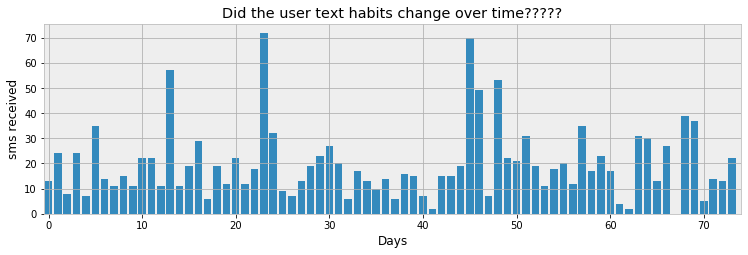

In [3]:
count_data = np.loadtxt("data/txtdata.csv")
n_count_data =len(count_data)
plt.bar(np.arange(n_count_data), count_data)
plt.xlabel("Days")
plt.ylabel("sms received")
plt.xlim(-0.5, n_count_data)
plt.title("Did the user text habits change over time?????")

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha = 1.0/count_data.mean() # count_data -> txt counts
    
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data -1)

In [9]:
with model:
    idx = np.arange(n_count_data) # create an index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

# because lambda_1, lambda_2 and tau are random, lambda_ will be random.    

In [12]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [14]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 9 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [19]:
lambda_1_samples = trace["lambda_1"]
lambda_2_samples = trace["lambda_2"]
tau_samples = trace["tau"]

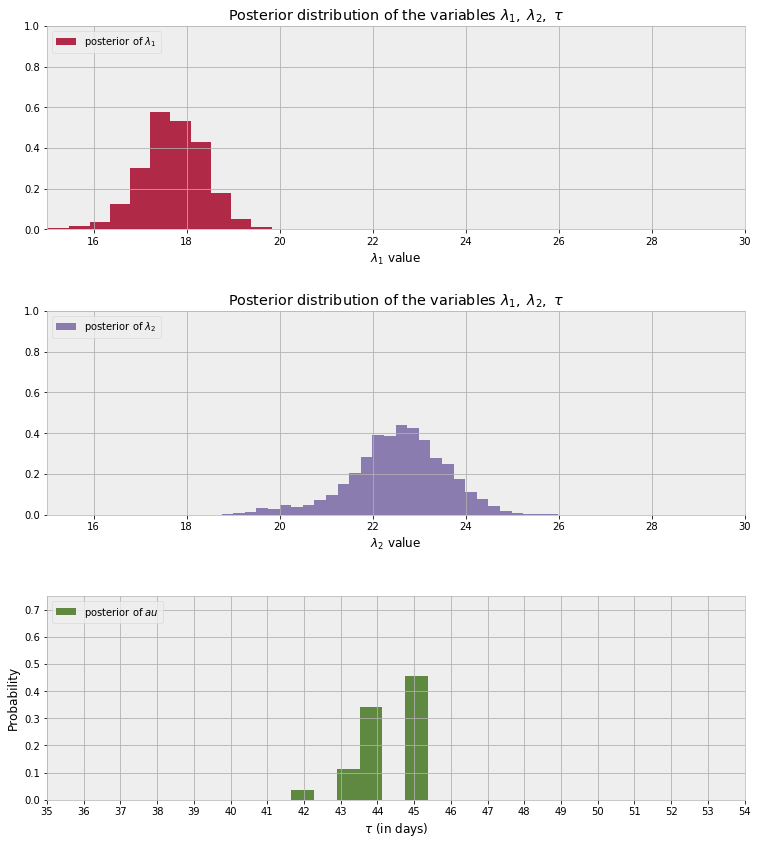

In [45]:
# plot these
figsize(12.5, 10)

#histogram
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype="stepfilled", bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distribution of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])

plt.xlabel("$\lambda_1$ value")

#histogram
ax = plt.subplot(312)
ax.set_autoscaley_on(False)

plt.hist(lambda_2_samples, histtype="stepfilled", bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distribution of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])

plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=0.85,
         label="posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data) - 20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("Probability")

plt.subplots_adjust(hspace=0.4, top=1.2)